In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan, linewidth=np.nan)
%matplotlib inline

In [2]:
# import xmltodict
from os import listdir
from os.path import join
def parse_annotations():
    """
    Parses annotation xml files of PASCAL VOC 2012.
    For images with multiple annotated objects, if the largest object is at least twice as large as the second largest one, then the label of that object is used as the label of the image.
    Compared to only using images with one annotated object, this allows another 3830 images. 
    It remains to be seen whether tiny objects (size ratio < 0.1) should be removed.
    Note that a few annotations contains non-integer bounding box and requires manual fix.
    Returns:
        df: Pandas dataframe of image name, label, and bounding box size ratio, of images with only one annotated object
        obj_count: collections.Counter instance for number of annotated objects in all images
    """
    def get_size(obj_annot):
        b = obj_annot['bndbox']  # size parameters are in str
        return (int(b['xmax']) - int(b['xmin'])) * (int(b['ymax']) - int(b['ymin']))
    annot_dir = '../pascal12/Annotations'
    objs = list()  # list<tuple<filename, label, size_ratio>>
    obj_counter = np.zeros(100, dtype=int)
    for x in listdir(annot_dir):
        with open(join(annot_dir, x), mode='r') as h:
            a = xmltodict.parse(h.read())['annotation']
            try:
                img_size = int(a['size']['width']) * int(a['size']['height'])
                if isinstance(a['object'], list):  # contains more than one annotated object
                    obj_sizes = map(get_size, a['object'])
                    sos = sorted(obj_sizes, reverse=True)  # sos for sorted_object_sizes
                    if sos[0] >= sos[1] * 2:
                        label = a['object'][np.argmax(obj_sizes)]['name']
                        size_ratio = float(sos[0]) / img_size
                        objs.append((a['filename'], label, size_ratio))
                    obj_counter[len(obj_sizes)] += 1
                else:
                    size_ratio = float(get_size(a['object'])) / img_size
                    objs.append((a['filename'], a['object']['name'], size_ratio))
                    obj_counter[1] += 1
            except:
                raise Exception('Error parsing {}'.format(x))
    df_raw = pd.DataFrame(objs, columns=['img', 'label', 'size_ratio'])
    df_raw['label'] = df_raw['label'].astype('category')
    counter_index = np.nonzero(obj_counter)[0]
    obj_count = dict(zip(counter_index, obj_counter[counter_index]))
    return df_raw, obj_count

In [3]:
import pickle
from os.path import isfile
def lazy_parse_annotations():
    cache = 'cache/annotations.pickle'
    if isfile(cache):
        with open(cache, mode='rb') as h:
            return pickle.load(h)
    else:
        df_raw, obj_count = parse_annotations()
        with open(cache, mode='wb') as h:
            pickle.dump((df_raw, obj_count), h)
        return df_raw, obj_count

In [4]:
df, obj_count = lazy_parse_annotations()

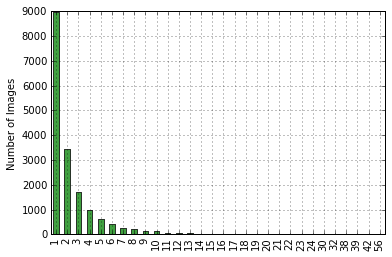

In [5]:
import pandas as pd
ax = pd.Series(obj_count).plot(kind='bar', color='green', alpha=0.75, grid=True)
ax.set_ylabel('Number of Images')
f = ax.get_figure()
# f.tight_layout()
# f.savefig('1.pdf')

In [6]:
# subsample 950 images from all "person" images to balance dataset
import random
df_person = df[df['label'] == 'person']
df_no_person = df.drop(df_person.index)
person_sample = df.ix[random.sample(list(df_person.index), 950)]
df = pd.concat([df_no_person, person_sample], ignore_index=True)

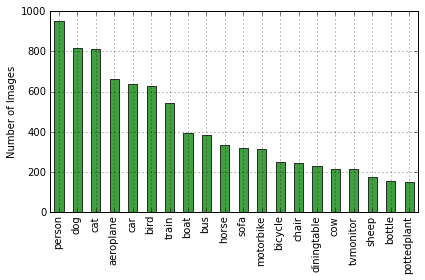

In [7]:
ax = df['label'].value_counts().plot(kind='bar', color='green', alpha=0.75, grid=True)
ax.set_ylabel('Number of Images')
f = ax.get_figure()
# f.tight_layout()
# f.savefig('2.pdf')

In [8]:
# convert labels from string to numerical
with open('cache/hex.pickle', mode='rb') as h:
    hex_data = pickle.load(h)
name_id = hex_data['name_id']
df['label'] = map(lambda x: name_id[x], df['label'])

In [9]:
# add edges
id_hls = hex_data['id_hierarchical_labels'][:20]  # id_hls for id_hierarchical_labels, leaf nodes only
id_fh, id_iph = zip(*map(lambda x: sorted(x, key=len, reverse=True)[:2], id_hls))
H_e = hex_data['H_e']
hierarchies = map(lambda x: id_fh[x], df['label'])
df['edges'] = map(lambda x: tuple(np.nonzero([e[0] in x and e[1] in x for e in H_e])[0]), hierarchies)

In [10]:
df.head()

,img,label,size_ratio,edges
0,2009_001061.jpg,10,0.995339,"(9, 14)"
1,2008_006600.jpg,8,0.007645,"(9, 12)"
2,2010_002200.jpg,11,0.198912,"(7,)"
3,2011_002107.jpg,10,0.947467,"(9, 14)"
4,2008_005436.jpg,16,0.606795,"(17, 21)"


In [ ]:
# split the dataset into 3:1:1 train/val/test subset
from sklearn.cross_validation import train_test_split
df_train_val, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_train_val, test_size=0.25)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
# val and test set are the same for all relabelling rate
with open('cache/df_val_test.pickle', mode='wb') as h:
    pickle.dump((df_val, df_test), h)

In [ ]:
# hierarchical relabel
for r in [0, 50, 90]:  # relabelling rate in percentage
    relabel = lambda x: id_iph[x] if random.random() < float(r)/100 else id_fh[x]
    df_train['pseudo_label'] = map(relabel, df_train['label'])
    with open('cache/df_train.{}.pickle'.format(r), mode='wb') as h:
        pickle.dump(df_train, h)